# Finding all facial landmarks

- run detector on full datset, find all face "candidates"
- filter them by probability
- run landmark coordinates regresson on all "good" faces
- save landmark coodrinates

In [39]:
%matplotlib inline

In [2]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl

import gc
import os
import pandas as pd
from PIL import Image
import mmcv
import requests
import time
import pickle

# mpl.use('TkAgg')
mpl.rcParams["figure.facecolor"] = 'w'
mpl.rcParams["axes.facecolor"] = 'w'
mpl.rcParams["savefig.facecolor"] = 'w'

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import json
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import cv2

In [3]:
def clear_GPU():
    gc.collect()
    torch.cuda.empty_cache()
    gc.collect()
    torch.cuda.empty_cache()

In [4]:
if 'nt' in os.name:
    num_workers = 0
    path = 'D:/DATASETS_ML/faces_dataset/'
else:
    num_workers = 8
    path = '/home/sergey/DATASETS_ML/faces_dataset/'
print('num_workers =', num_workers)

num_workers = 8


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [6]:
ds_path = '/home/sergey/DATASETS_ML/celebA_full/'
proj_path = os.getcwd()
landmark_path = os.getcwd() + '/models/landmark/'
detefction_path = os.getcwd() + '/models/detection/'

# tabular data
table_path = os.getcwd() + '/tables/'
bbox_path = table_path + '/detected_bboxes.cvs'
fin_landmark_path = table_path + '/final_landmarks.pkl'
det_landmark_path = table_path + '/detected_landmarks.pkl'

# Import models

Landmark regressor.

In [7]:
class FaceRegressionModel(nn.Module):
    def __init__(self, backbone, num_points=5, hidden_size=2**11):
        '''
        backbone - CNN for reature extraction
        num_points - number of predicted points (each point has two coordinates)
        hidden_size - number of neurons in hidden FC layer before output layer
        '''
        super(FaceRegressionModel, self).__init__()
        self.num_points = num_points
        self.backbone = backbone

        self.head = nn.Sequential(
            nn.Flatten(), # now the head can work with any conv result
            nn.LazyLinear(hidden_size),
            nn.LeakyReLU(0.05),
            nn.LazyLinear(num_points * 2)
        )

    def forward(self, tensor):
        tensor = self.backbone(tensor)
        tensor = self.head(tensor)
        tensor = tensor.view(tensor.shape[0], self.num_points, -1)
        return tensor

YOLO detector.

In [8]:
detector = torch.hub.load('ultralytics/yolov5',
                           'custom', 
                           path=detefction_path+'best.pt', 
                           force_reload=True, 
                          )

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to /home/sergey/.cache/torch/hub/master.zip
YOLOv5 🚀 2022-7-3 Python-3.9.7 torch-1.11.0+cu113 CUDA:0 (NVIDIA GeForce RTX 3060, 12031MiB)

Fusing layers... 
Model summary: 213 layers, 7012822 parameters, 0 gradients
Adding AutoShape... 


# Prepare dataset

In [9]:
files = []

for dirpath, dirnames, filenames in os.walk(ds_path+'img_celeba'):
    for fname in filenames:
        fpath = os.path.join(ds_path+'img_celeba', fname)
        files.append(fpath)

In [10]:
files = sorted(files)

In [11]:
class UncroppedDataset(Dataset):
    def __init__(self, files_list):
        self.files = files_list
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        return self.files[idx]

# Find BBoxes

In [12]:
clear_GPU()

ds = UncroppedDataset(files)
dl = DataLoader(ds, 
                batch_size=300, 
                num_workers=num_workers)

bbox_list = []

for f in tqdm(dl):
    res = detector(f)
    res = res.xyxy
    res = [a.cpu().numpy() for a in res]
    bbox_list.extend(res)

  0%|          | 0/676 [00:00<?, ?it/s]

In [13]:
len(bbox_list)

202599

Transform bboxes to single np array.

In [14]:
image_idx_list = []
bbox_idx_list = []
files_list = []

for image_idx, bboxes in enumerate(bbox_list):
    for bbox_idx, bbox in enumerate(bboxes):
        image_idx_list.append(image_idx)
        files_list.append(files[image_idx])
        bbox_idx_list.append(bbox_idx)
        
image_idx_list = np.array(image_idx_list)[:,None]
bbox_idx_list = np.array(bbox_idx_list)[:,None]

To DataFrame.

In [15]:
tmp = np.concatenate([np.vstack(bbox_list), image_idx_list, bbox_idx_list], 1)
columns = ['x1', 'y1', 'x2', 'y2', 'prob', 'class', 'image_idx', 'bbox_idx']
bbox_df = pd.DataFrame(tmp, columns=columns)
bbox_df = bbox_df.drop(columns='class')
bbox_df[['image_idx', 'bbox_idx']] = bbox_df[['image_idx', 'bbox_idx']].astype(int)
bbox_df['bbox_count'] = bbox_df.groupby('image_idx')['bbox_idx'].transform('count').astype(int)
bbox_df['file'] = pd.Series(files_list)
bbox_df.head()

,x1,y1,x2,y2,prob,image_idx,bbox_idx,bbox_count,file
0,97.129745,71.833961,318.895782,380.629730,0.946586,0,0,1,/home/sergey/DATASETS_ML/celebA_full/img_celeb...
1,70.320709,94.198738,291.505341,400.276886,0.955572,1,0,1,/home/sergey/DATASETS_ML/celebA_full/img_celeb...
2,210.512192,62.626431,295.257965,179.285965,0.818118,2,0,1,/home/sergey/DATASETS_ML/celebA_full/img_celeb...
3,563.244446,225.734924,1180.686279,1075.231323,0.867229,3,0,1,/home/sergey/DATASETS_ML/celebA_full/img_celeb...
4,236.021027,100.996231,365.401611,275.952026,0.917988,4,0,1,/home/sergey/DATASETS_ML/celebA_full/img_celeb...


Save to file.

In [16]:
bbox_df.to_csv(bbox_path)

In [17]:
bbox_df = pd.read_csv(bbox_path, index_col=0)
bbox_df.head()

,x1,y1,x2,y2,prob,image_idx,bbox_idx,bbox_count,file
0,97.129745,71.833961,318.895782,380.629730,0.946586,0,0,1,/home/sergey/DATASETS_ML/celebA_full/img_celeb...
1,70.320709,94.198738,291.505341,400.276886,0.955572,1,0,1,/home/sergey/DATASETS_ML/celebA_full/img_celeb...
2,210.512192,62.626431,295.257965,179.285965,0.818118,2,0,1,/home/sergey/DATASETS_ML/celebA_full/img_celeb...
3,563.244446,225.734924,1180.686279,1075.231323,0.867229,3,0,1,/home/sergey/DATASETS_ML/celebA_full/img_celeb...
4,236.021027,100.996231,365.401611,275.952026,0.917988,4,0,1,/home/sergey/DATASETS_ML/celebA_full/img_celeb...


Lets see if there are any images with 2 or more bbox.

In [18]:
pd.DataFrame([bbox_df['bbox_count'].value_counts(), bbox_df['bbox_count'].value_counts()/len(files)]).T

,bbox_count,bbox_count
1,200918.0,0.991703
2,2804.0,0.013840
3,249.0,0.001229
4,28.0,0.000138
5,10.0,0.000049
6,6.0,0.000030


There are some, yes.

We'll just drop them!

In [19]:
a = bbox_df[bbox_df['bbox_count'] == 1]
a = a.sort_values(['prob'])
a.head()

,x1,y1,x2,y2,prob,image_idx,bbox_idx,bbox_count,file
6870,76.253838,114.610710,162.973511,228.501251,0.250393,6837,0,1,/home/sergey/DATASETS_ML/celebA_full/img_celeb...
21479,504.284760,149.746170,544.819702,208.992249,0.250989,21338,0,1,/home/sergey/DATASETS_ML/celebA_full/img_celeb...
1736,709.588867,524.466553,909.696594,753.789673,0.251738,1733,0,1,/home/sergey/DATASETS_ML/celebA_full/img_celeb...
180305,110.586517,227.124298,177.359283,309.399628,0.252127,179047,0,1,/home/sergey/DATASETS_ML/celebA_full/img_celeb...
67498,109.228027,69.050919,259.708221,279.664459,0.252140,67061,0,1,/home/sergey/DATASETS_ML/celebA_full/img_celeb...


# Dataset for landmark regression

In [20]:
class CroppedDataset(Dataset):
    def __init__(self, df_in, regresson_config_path):
        self.df = df_in
        
        with open(regresson_config_path) as infile:
            cfg = json.load(infile)
        
        self.stats = cfg['mean'], cfg['std']
        self.img_size = cfg['input_size'][1]

        self.basic_transform = A.Compose([
                A.Resize(self.img_size, self.img_size),
                A.Normalize(*self.stats),
                ToTensorV2(),
            ])
    
    def __len__(self):
        return len(self.df)
    
    def denorm(self, img_tensors):
        img_tensors = img_tensors * self.stats[1][0] + self.stats[0][0]
        if type(img_tensors) == torch.Tensor:
            img = img_tensors.cpu().permute(1,2,0).numpy()
        elif type(img_tensors) == np.ndarray:
            img = np.transpose(img_tensors, (1,2,0))
        img = np.clip(img, 0, 1)
        return img
    
    def imshow(self, img_tensor):
        img = self.denorm(img_tensor)
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        fname = row['file']
        image = cv2.imread(fname)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        x1 = int(row['x1'])
        x2 = int(row['x2'])
        y1 = int(row['y1'])
        y2 = int(row['y2'])
        
        image = image[y1:y2, x1:x2]
        
        return self.basic_transform(image=image)['image']

In [21]:
ds = CroppedDataset(bbox_df, 
                    regresson_config_path=landmark_path+'/best_landmark_model_cfg.txt')
dl = DataLoader(ds, 
                batch_size=500, 
                num_workers=num_workers,
                shuffle=False)

# Find landmark coordinates

In [22]:
regressor = torch.load(landmark_path+'/best_landmark_model.pt', 
                       map_location=torch.device(device))
regressor.eval();

In [23]:
landmarks = []

for im_batch in tqdm(dl):
    im_batch = im_batch.to(device)
    with torch.no_grad():
        res = regressor(im_batch)
    res = res.cpu().numpy()
    res = res
    landmarks.append(res)
    
landmarks = np.concatenate(landmarks, 0)

  0%|          | 0/409 [00:00<?, ?it/s]

In [24]:
landmarks.shape

(204015, 5, 2)

Transform local coordinates to full-image coordinates.

In [25]:
%%time
df = bbox_df.copy()
df['lm'] = pd.Series([i.copy() for i in landmarks])

def calculate_abs_landmarks(row):
    arr = row['lm'].copy()
    arr[:,0] = (row['x1'] + row['x2']) / 2 + arr[:,0] * (row['x2'] - row['x1'])
    arr[:,1] = (row['y1'] + row['y2']) / 2 + arr[:,1] * (row['y2'] - row['y1'])
    return arr

df['lm_abs'] = df.apply(calculate_abs_landmarks, axis=1)

CPU times: user 3.12 s, sys: 149 ms, total: 3.27 s
Wall time: 3.16 s


In [26]:
df.head()

,x1,y1,x2,y2,prob,...,bbox_idx,bbox_count,file,lm,lm_abs
0,97.129745,71.833961,318.895782,380.629730,0.946586,...,0,1,/home/sergey/DATASETS_ML/celebA_full/img_celeb...,"[[-0.18993533, -0.13224384], [0.16779032, -0.1...","[[165.89156, 185.39551], [245.22295, 176.5262]..."
1,70.320709,94.198738,291.505341,400.276886,0.955572,...,0,1,/home/sergey/DATASETS_ML/celebA_full/img_celeb...,"[[-0.1800476, -0.13378587], [0.17763418, -0.13...","[[141.08926, 206.28888], [220.20297, 205.88448..."
2,210.512192,62.626431,295.257965,179.285965,0.818118,...,0,1,/home/sergey/DATASETS_ML/celebA_full/img_celeb...,"[[-0.08188743, -0.14684221], [0.10981281, -0.1...","[[245.94545, 103.82565], [262.19125, 105.72919..."
3,563.244446,225.734924,1180.686279,1075.231323,0.867229,...,0,1,/home/sergey/DATASETS_ML/celebA_full/img_celeb...,"[[-0.118269525, -0.14782156], [0.18102467, -0....","[[798.9408, 524.9093], [983.73755, 533.18665],..."
4,236.021027,100.996231,365.401611,275.952026,0.917988,...,0,1,/home/sergey/DATASETS_ML/celebA_full/img_celeb...,"[[-0.21310681, -0.110190876], [0.19189812, -0....","[[273.1394, 169.19559], [325.53918, 160.43056]..."


In [27]:
df.to_pickle(det_landmark_path)

In [28]:
df_full = pd.read_pickle(det_landmark_path)
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204015 entries, 0 to 204014
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   x1          204015 non-null  float64
 1   y1          204015 non-null  float64
 2   x2          204015 non-null  float64
 3   y2          204015 non-null  float64
 4   prob        204015 non-null  float64
 5   image_idx   204015 non-null  int64  
 6   bbox_idx    204015 non-null  int64  
 7   bbox_count  204015 non-null  int64  
 8   file        204015 non-null  object 
 9   lm          204015 non-null  object 
 10  lm_abs      204015 non-null  object 
dtypes: float64(5), int64(3), object(3)
memory usage: 18.7+ MB


In [29]:
df_full.head()

,x1,y1,x2,y2,prob,...,bbox_idx,bbox_count,file,lm,lm_abs
0,97.129745,71.833961,318.895782,380.629730,0.946586,...,0,1,/home/sergey/DATASETS_ML/celebA_full/img_celeb...,"[[-0.18993533, -0.13224384], [0.16779032, -0.1...","[[165.89156, 185.39551], [245.22295, 176.5262]..."
1,70.320709,94.198738,291.505341,400.276886,0.955572,...,0,1,/home/sergey/DATASETS_ML/celebA_full/img_celeb...,"[[-0.1800476, -0.13378587], [0.17763418, -0.13...","[[141.08926, 206.28888], [220.20297, 205.88448..."
2,210.512192,62.626431,295.257965,179.285965,0.818118,...,0,1,/home/sergey/DATASETS_ML/celebA_full/img_celeb...,"[[-0.08188743, -0.14684221], [0.10981281, -0.1...","[[245.94545, 103.82565], [262.19125, 105.72919..."
3,563.244446,225.734924,1180.686279,1075.231323,0.867229,...,0,1,/home/sergey/DATASETS_ML/celebA_full/img_celeb...,"[[-0.118269525, -0.14782156], [0.18102467, -0....","[[798.9408, 524.9093], [983.73755, 533.18665],..."
4,236.021027,100.996231,365.401611,275.952026,0.917988,...,0,1,/home/sergey/DATASETS_ML/celebA_full/img_celeb...,"[[-0.21310681, -0.110190876], [0.19189812, -0....","[[273.1394, 169.19559], [325.53918, 160.43056]..."


# Filter probabilities

Lets drop images with low probability of face inside a bbox.

In [30]:
tmp = df_full[df_full['prob'] > 0.8]
tmp = tmp.drop(columns = 'bbox_count')
tmp['bbox_count'] = tmp.groupby('image_idx')['bbox_idx'].transform('count').astype(int)
tmp = tmp[tmp['bbox_count'] == 1]
len(tmp)

190375

Here are some images with low probabilities.

In [31]:
for row in tmp.sort_values('prob').head(20).iterrows():
    fig, ax = plt.subplots(figsize=(3,3))
    i = row[0]
    row = row[1]
    image = cv2.imread(row['file'])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    c = row['lm_abs']
    plt.imshow(image)
    plt.scatter(c[:,0], c[:,1], c='b', edgecolor='w')
    rect = mpl.patches.Rectangle((row['x1'], row['y1']), 
                                 row['x2']-row['x1'], row['y2']-row['y1'], 
                                 linewidth=3, edgecolor='r', facecolor='none')
    plt.axis('off')
    plt.show()

/tmp/ipykernel_144278/2236632511.py:14: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


They are all people, yes. But most faces are somehow rotated.

# Add info about a person

In [32]:
def get_annot_df(ds_path):

    persons = mmcv.list_from_file(ds_path + 'Anno/identity_CelebA.txt')
    persons = [i.split() for i in persons]
    cols = ['image_id'] + persons[0]
    persons = pd.DataFrame(persons, columns=['image_id', 'person'])
    persons = persons.set_index('image_id')
    persons = persons.astype(int)
    
    partitions = mmcv.list_from_file(ds_path + 'Anno/list_eval_partition.txt')
    partitions = [i.split() for i in partitions]
    partitions = pd.DataFrame(partitions, columns=['image_id', 'part'])
    partitions = partitions.set_index('image_id')
    partitions = partitions.astype(int)
    
    df = persons.join([partitions]).reset_index(drop=False)
    
    df = df.rename(columns=dict(
        x_1 = 'bbox_hor_top',
        y_1 = 'bbox_ver_top',
    ))
    
    for c in df.columns:
        if '_x' in c:
            df[c] = df[c] - df['bbox_hor_top']
        if '_y' in c:
            df[c] = df[c] - df['bbox_ver_top']

    return df

df_annot = get_annot_df(ds_path)
df_annot.head()

,image_id,person,part
0,000001.jpg,2880,0
1,000002.jpg,2937,0
2,000003.jpg,8692,0
3,000004.jpg,5805,0
4,000005.jpg,9295,0


In [33]:
tmp['image_id'] = tmp['file'].str.split('/').apply(lambda x: x[-1])
tmp.head()

,x1,y1,x2,y2,prob,...,file,lm,lm_abs,bbox_count,image_id
0,97.129745,71.833961,318.895782,380.629730,0.946586,...,/home/sergey/DATASETS_ML/celebA_full/img_celeb...,"[[-0.18993533, -0.13224384], [0.16779032, -0.1...","[[165.89156, 185.39551], [245.22295, 176.5262]...",1,000001.jpg
1,70.320709,94.198738,291.505341,400.276886,0.955572,...,/home/sergey/DATASETS_ML/celebA_full/img_celeb...,"[[-0.1800476, -0.13378587], [0.17763418, -0.13...","[[141.08926, 206.28888], [220.20297, 205.88448...",1,000002.jpg
2,210.512192,62.626431,295.257965,179.285965,0.818118,...,/home/sergey/DATASETS_ML/celebA_full/img_celeb...,"[[-0.08188743, -0.14684221], [0.10981281, -0.1...","[[245.94545, 103.82565], [262.19125, 105.72919...",1,000003.jpg
3,563.244446,225.734924,1180.686279,1075.231323,0.867229,...,/home/sergey/DATASETS_ML/celebA_full/img_celeb...,"[[-0.118269525, -0.14782156], [0.18102467, -0....","[[798.9408, 524.9093], [983.73755, 533.18665],...",1,000004.jpg
4,236.021027,100.996231,365.401611,275.952026,0.917988,...,/home/sergey/DATASETS_ML/celebA_full/img_celeb...,"[[-0.21310681, -0.110190876], [0.19189812, -0....","[[273.1394, 169.19559], [325.53918, 160.43056]...",1,000005.jpg


In [34]:
df_final = tmp.merge(df_annot, on='image_id', how='left', validate='many_to_one')
df_final['w'] = df_final['x2'] - df_final['x1']
df_final['h'] = df_final['y2'] - df_final['y1']
col_drop = ['bbox_count', 'prob', 'lm', 'image_idx', 'bbox_idx', 'x1', 'x2', 'y1', 'y2']
df_final = df_final.drop(columns=col_drop)
df_final = df_final.set_index('image_id')
df_final.head()

,file,lm_abs,person,part,w,h
image_id,,,,,,
000001.jpg,/home/sergey/DATASETS_ML/celebA_full/img_celeb...,"[[165.89156, 185.39551], [245.22295, 176.5262]...",2880,0,221.766037,308.795769
000002.jpg,/home/sergey/DATASETS_ML/celebA_full/img_celeb...,"[[141.08926, 206.28888], [220.20297, 205.88448...",2937,0,221.184631,306.078148
000003.jpg,/home/sergey/DATASETS_ML/celebA_full/img_celeb...,"[[245.94545, 103.82565], [262.19125, 105.72919...",8692,0,84.745773,116.659534
000004.jpg,/home/sergey/DATASETS_ML/celebA_full/img_celeb...,"[[798.9408, 524.9093], [983.73755, 533.18665],...",5805,0,617.441833,849.496399
000005.jpg,/home/sergey/DATASETS_ML/celebA_full/img_celeb...,"[[273.1394, 169.19559], [325.53918, 160.43056]...",9295,0,129.380585,174.955795


Aaaaand save.

In [35]:
df_final.to_pickle(fin_landmark_path)

# Number of images per person

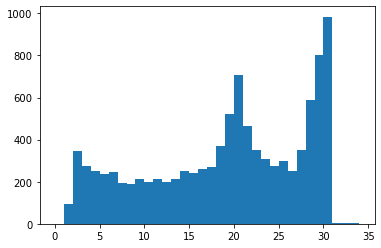

In [40]:
df_final['count'] = df_final.groupby('person')['w'].transform('count')
plt.hist(df_final.groupby('person')['w'].count(), bins = np.arange(0, 35, 1));

There are some classes (few hundreds) havind less than 5 photos!